In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os

# Week 1: Pulsars and Image Stacking

After a supernova, a star collapses into a smaller but dense neutron star. By conservation of angular momentum, it’s rotation speed increases after collapse. Also, like the Earth, stars have magnetic fields. And when a star collapses, it takes the fields with it. So, neutron stars would have incredibly intense magnetic fields. Charged particles in the super-hot plasma surrounding a neutron star, would get funneled towards the star's magnetic poles and shot out into space as two intense beams. Putting these two ideas together, a neutron star becomes a bit like a lighthouse, rapidly spinning in space, flashing its energy beams across the universe.

Typical MWA(Murchison Widefield Array) Image:


![Image](https://imgur.com/OTQJxjQ.png)

In radio astronomy, flux density is measured in units of Janskys:

$
1 Jy = 10^{-26} W m^{-2} Hz ^{-1}
$

![Image](https://imgur.com/024TFNI.png)

Some people like to display their images in false color, but remember, radio frequencies don't have color. These color maps are just used to accentuate different aspects of the intensity scale.


### Detection:
Typically, a signal is classified as the destection if the flux density is more than 5 standard deviations higher than the noise in the local region.


When we don't detect something, it could be for a whole range of reasons. It could be that the pulsar is too far away, it could be the intrinsic emission isn't strong at these frequencies, or it could be that the emission is intermittent and switched off.

Stacking allows us to measure the statistical properties of a population we can't detect.Stacking works because the noise in a radio image is roughly random, with a Gaussian distribution centered on zero. When you add regions of an image that just have noise, the random numbers cancel out. But when you add regions of an image in which there are signals, the signals add together, increasing what we call the signal to noise ratio.


![Img](https://imgur.com/oN7ZZet.jpg)

### Astropy and FITS:
One of the most widely used formats for astronomical images is the Flexible Image Transport System. In a FITS file, the image is stored in a numerical array, which we can load into a NumPy array. FITS files also have headers which store metadata about the image.
To improve the robustness of this method to outliers, we implement a median stack instead of using the mean. Now, the above methods involved holding all the images in memory at once. This is a bad idea if there are a lot of images.

We can instead calculate a running mean, i.e, calculate the mean cumulatively, while holding only one image in memory at a time. This can easily be done for the mean, but not for the median. Instead, we can use an approximation for the median, called the Bin-Approx Algorithm.


### Bin-Approx Algorithm:
The Bin-Approx Algorithm saves even more time and space by only looking for the median within one standard deviation of the mean (see the link if you’d like to know why that works).

The full algorithm for a set of N data points is as follows:

1) Calculate their mean and standard deviation, μ and σ.

2) Set the bounds: minval =  μ − σ and maxval =  μ + σ. Any value >= maxval is ignored

3) Set the bin width: width =  2σ/B

4) Make an ignore bin for counting value < minval

5) Make B bins for counting values in minval and maxval, e.g. the first bin is minval <= value < minval + width

6) Count the number of values that fall into each bin

7) Sum these counts until total >= (N + 1)/2. Remember to start from the ignore bin.

8) Return the midpoint of the bin whose cumulative sum exceeds (N + 1)/2


![Img](https://imgur.com/EgOmNbr.jpg)

In [2]:
# Write your load_fits function here.
def load_fits(name):
    hdulist = fits.open(name)
    data = hdulist[0].data
    #Return max index (2d index)
    #data.argmax() flattens the array and gives index of max value
    #We unravel it using unravel_index()
    return np.unravel_index(data.argmax(), data.shape)


def plot_fits_image(data):
    # Plot the 2D image data
    plt.imshow(data.T, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.show()

In [3]:
def running_stats(filenames):
    '''Calculates the running mean and stdev for a list of FITS files using Welford's method.'''
    n = 0
    for filename in filenames:
        hdulist = fits.open(filename)
        data = hdulist[0].data
        if n == 0:
            mean = np.zeros_like(data)
        s = np.zeros_like(data)
        n += 1
        delta = data - mean
        mean += delta/n
        s += delta*(data - mean)
        hdulist.close()
    s /= n - 1
    np.sqrt(s, s)
    if n < 2:
        return mean, None
    else:
        return mean, s

In [4]:
def bin_approx_median(filenames, B):
    N = len(filenames)
    mid = (N + 1)/2
    mean_arr ,std_arr = running_stats(filenames)
    x,y = mean_arr.shape        #To create new arrays, we want shape of image: width x and height y
    ignore_bin = np.zeros((x,y))    #Ignore bin is a 2D array identical to image shape, i.e x*y ignore_bins for x*y pixels
    bin_arr = np.zeros((x,y,B))         #Apart from ignore bin, each of the x*y pixels will have B bins thus shape (x,y,B)
    bin_width_arr = 2*std_arr/B
    for name in filenames:
        hdulist = fits.open(name)
        data = hdulist[0].data
        for i in range(x):
            for j in range(y):
                pixel_val = data[i,j]
                mean = mean_arr[i,j]
                std = std_arr[i,j]
                min_val = mean - std
                max_val = mean + std
                bin_width = 2*std/B
                
                if pixel_val < min_val:
                    ignore_bin[i,j] +=1
                elif pixel_val >= max_val:
                    pass
                else:
                    bin_choice = int((pixel_val - (mean - std))/bin_width)
                    bin_arr[i,j,bin_choice]+=1
    #We now have bin_arr
    median_arr = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            count = ignore_bin[i, j]
            for b, bincount in enumerate(bin_arr[i, j]):
                count += bincount
                if count >= mid:
                    # Stop when the cumulative count exceeds the midpoint
                    break
            median_arr[i, j] = mean_arr[i, j] - std_arr[i, j] + bin_width_arr[i, j]*(b + 0.5)    
    return median_arr

In [5]:
median = bin_approx_median([os.path.join("Week 1",'image{}.fits').format(str(i)) for i in range(11)], 4)

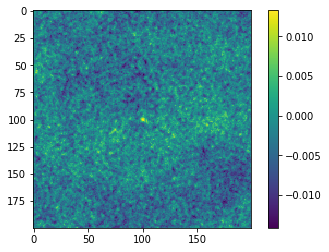

In [6]:
plot_fits_image(median)

### Results:

We wanted to find how many pulsars were emitting at the radio frequencies detected by the MWA. Initially, our investigation showed that most were not detected. But we decided to use mean (and then later median) stacking to improve our signal to noise ratio and make a statistical detection of the invisible population. Median stacking for a large population took a lot of computation and thus we used the Bin-Approx algorithm to save computational time. After stacking, we were able to successfully detect the pulsar.

### Further Reading:

1) Introduction to Pulsars (from CSIRO, beginner) Hobbs, M. (n.d.). An introduction to pulsars. Retrieved February 14, 2017, from http://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html

2) Pulsar Properties (from NRAO, advanced) National Radio Astronomy Observatory. (2010). Pulsar Properties. Retrieved February 14, 2017, from http://www.cv.nrao.edu/course/astr534/Pulsars.html

3) Image stacking to detect quasars White, R. L., Helfand, D. J., Becker, R. H., Glikman, E., & de Vries, W. (2007). Signals from the noise: Image stacking for quasars in the FIRST survey. The Astrophysical Journal, 654(1), 99-114. doi:10.1086/507700

4) Stacking of radio images to study faint, high-redshift galaxies
Lindroos, L., Knudsen, K., Vlemmings, W., Conway, J., Marti-Vidal, I. (2015). Stacking of large interferometric data sets in the image- and uv-domain - a comparative study. Monthly Notices of the Royal Astronomical Society, 446(4), 3502-3515. doi:10.1093/mnras/stu2344

5) Radio visibility stacking to search for Type 1a supernova Hancock, P. P., Gaensler, B. M., & Murphy, T. (2011). Visibility stacking in the quest for type ia supernova radio emission. Astrophysical Journal Letters, 735(2) doi:10.1088/2041-8205/735/2/L35

6) Fast Computation of the Median by Successive Binning
http://www.stat.cmu.edu/~ryantibs/papers/median.pdf

# Week 2: Cross Matching


Now say you've carried out two surveys: one in radio bands and another in optical bands. To combine this information together, we need to match the objects in the radio survey with the objects in the optical survey.

To do this, we create a catalogue of objects from each survey, and then do a positional cross-match.

The process of positional cross-matching seems pretty straightforward, but it doesn't scale well with the size of the catalog.

When we create a catalog from survey images, we start by extracting a list of sources, galaxies and stars, using source-finding software, say sExtractor. This software runs through the pixels in an image and find peaks that are statistically significant.

Then, they group the surrounding pixels and fit a function (called beam/point spread function), which results in a list of objects, each of which has a position, an angular size and an intensity measurement.

Once we have our catalogues, cross-matching involves searching the second catalogue to find a counterpart for each object in the first catalogue. To do this, we usually search within a given radius, based on the uncertainties in the position.

The algorithm can be described as:
![Img](https://imgur.com/R3M4Lp9.jpg)

The problem with this, however, is that it doesn't scale well since it has $\mathcal{O}(n^2)$ time complexity.

In this activity you'll cross-match two catalogues: one from a radio survey, the [AT20G Bright Source Sample (BSS) catalogue](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) (radio spectrum) and one from an optical survey, the [SuperCOSMOS all-sky galaxy catalogue](http://ssa.roe.ac.uk/allSky) (visible spectrum).

We've chosen one small catalogue (BSS has only 320 objects) and one large one (SuperCOSMOS has about 240 million) to demonstrate the issues you can encounter when implementing cross-matching algorithms.

Right ascension is often given in hours-minutes-seconds (HMS) notation, because it was convenient to calculate when a star would appear over the horizon. A full circle in HMS notation is 24 hours, which means 1 hour in HMS notation is equal to 15 degrees. Each hour is split into 60 minutes and each minute into 60 seconds.

Declination, on the other hand, is traditionally recorded in degrees-minutes-seconds (DMS) notation. A full circle is 360 degrees, each degree has 60 arcminutes and each arcminute has 60 arcseconds.

#### Note: arcminutes and minutes are different!
The arcminutes and arcseconds in DMS are not the same as the minutes and seconds in HMS! A minute in HMS is equal to 15 arcminutes in DMS and a second is equal to 15 arcseconds.



In [7]:
def hms2dec(h,m,s):
    #Function to convert HMS to decimal degress
    tot_hrs = (h + m/60 + s/3600)
    deg = 15*tot_hrs #(1 hour in HMS notation is equal to 15 degrees)
    return deg

def dms2dec(d,m,s):
    #Function to convert DMS to decimal degress
    if d < 0:
        sign = -1
    else:
        sign = 1
    deg = sign*(abs(d) + m/60 + s/3600)
    return deg


To crossmatch two catalogues we need to compare the angular distance between objects on the celestial sphere. We'll calculate angular distance using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula), which is good at avoiding floating point errors when the two points are close together.

The formula is as follows:

$
d = 2\:\arcsin \sqrt{\sin^2\frac{\mid{\delta_1 - \delta_2}\mid}{2}+ \cos{\delta_1} \cos{\delta_2} \sin^2\frac{\mid{\alpha_1 - \alpha_2}\mid}{2}}
$

In [8]:
def angular_dist(ra1, dec1, ra2, dec2):
    '''
    Function takes arguments in decimal degrees and return the distance in decimal degrees.
    '''
    # Convert to radians
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    ra2 = np.radians(ra2)
    dec2 = np.radians(dec2)

    a = np.sin(np.abs(dec1 - dec2)/2)**2
    b = np.cos(dec1)*np.cos(dec2)*np.sin(np.abs(ra1 - ra2)/2)**2

    angle = 2*np.arcsin(np.sqrt(a + b))
    # Convert back to degrees
    return np.degrees(angle)

### Data
Every astronomy catalogue tends to have its own unique format so we'll need to look at how to do this with each one individually.

We'll look at the AT20G bright source sample survey first. The raw data we'll be using is the file table2.dat from [this](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) page in the VizieR archives, but we'll use the filename bss.dat from now on.

Every catalogue in VizieR has a detailed README file that gives you the exact format of each table in the catalogue.

The catalogue is organised in fixed-width columns, with the format of the columns being:

1: Object catalogue ID number (sometimes with an asterisk)

2-4: Right ascension in HMS notation

5-7: Declination in DMS notation

8-: Other information, including spectral intensities

We only need coordinates for crossmatching. 

The SuperCOSMOS all-sky catalogue is a catalogue of galaxies generated from several visible light surveys.

The original data is available on [this](http://ssa.roe.ac.uk/allSky) page in a package called SCOS_XSC_mCl1_B21.5_R20_noStepWedges.csv.gz. Because this catalogue is so large, we've cut it down for these activities. The cut down version of the file will be named super.csv.

Aside from the first row, which contains column labels, the format is:

1: Right ascension in decimal degrees

2: Declination in decimal degrees

3: Other data, including magnitude and apparent shape



In [9]:
'''
Each function returns a list of tuples containing the object's ID (an integer) and the coordinates in degrees.
The object ID is the row of the object in the catalogue, starting at 1.
'''
def import_bss():
    arr = np.loadtxt(os.path.join("Week 2",'bss.dat'), usecols=range(1, 7))
    ls=[]
    for i,row in enumerate(arr):
        h=row[0]
        m1=row[1]
        s1=row[2]
        ra = hms2dec(h,m1,s1)
        d=row[3]
        m2=row[4]
        s2=row[5]
        dec = dms2dec(d,m2,s2)
        tup = i+1, ra, dec
        ls.append(tup)
    return ls

def import_super():
    arr = np.loadtxt(os.path.join("Week 2",'super.csv'), delimiter=',', skiprows=1, usecols=[0, 1])
    ls=[]
    for i,row in enumerate(arr):
        ra = row[0]
        dec = row[1]
        tup = i+1, ra, dec
        ls.append(tup)
    return ls

In [10]:
def find_closest(cat,ra,decl):
    min_dist = np.inf
    min_obj = None
    for elem in cat:
        obj_id, ra2, decl2 = elem
        dist = angular_dist(ra,decl,ra2,decl2)
        if dist < min_dist:
            min_obj=obj_id
            min_dist = dist
    return min_obj,min_dist

In [11]:
def crossmatch(cat1,cat2,max_dist):
    matches=[]
    no_matches = []
    for elem1 in cat1:
        obj_id1,ra1,decl1 = elem1
        min_dist = np.inf
        min_obj2 = None
        for elem2 in cat2:
            obj_id2,ra2,decl2 = elem2
            dist = angular_dist(ra1,decl1,ra2,decl2)
            if dist<min_dist:
                min_obj2=obj_id2
                min_dist = dist
        #Check once loop has finished
        if min_dist<max_dist:
            append_elem = obj_id1,min_obj2,min_dist
            matches.append(append_elem)
        else:
            no_matches.append(obj_id1)
            #Only return obj_id of element from 2nd catalogue
    return matches, no_matches

In [12]:
if __name__ == '__main__':
    bss_cat = import_bss()
    super_cat = import_super()

    # First example in the question
    max_dist = 40/3600
    matches, no_matches = crossmatch(bss_cat, super_cat, max_dist)
    print(matches[:3])
    print(no_matches[:3])
    print(len(no_matches))

    # Second example in the question
    max_dist = 5/3600
    matches, no_matches = crossmatch(bss_cat, super_cat, max_dist)
    print(matches[:3])
    print(no_matches[:3])
    print(len(no_matches))

[(1, 2, 0.00010988610938710059), (2, 4, 0.0007649845967242494), (3, 5, 0.00020863352870707666)]
[5, 6, 11]
151
[(1, 2, 0.00010988610938710059), (2, 4, 0.0007649845967242494), (3, 5, 0.00020863352870707666)]
[5, 6, 11]
197


As we saw earlier, this has time complexity of $\mathcal{O}(n^2)$ if both catalogues have size n, or more generally $\mathcal{O}(n m)$ if size of each catalogue is n and m, respectively.

![Img](https://imgur.com/ksBBl2p.jpg)


Now, if the galaxies in our second catalog were sorted in order of their Declination, then as soon as we reach a point that's further away from that position, we could break out of our loop. There's no need to cross match our galaxy with anything further away than this.

This will roughly improve our computation speed by a factor of 2.

For 2 catalogues with a million sources, that would reduce the computation time from 24 days to 12 days. But, we still haven't actually improved the worst case time complexity.

Often, we can implement some practical improvements as above, without changing the formal time complexity (Big Oh). What we've done is reduce the constant factors in our time complexy equation. 

Thus, we can speed up a program by:
![TimeComplexityImage](https://imgur.com/7MxtnOM.jpg)

### k-d Trees

If we use Astropy's inbuilt crossmatching feature, it took only 25 seconds as compared to 12/24 days before. This is done with the help of a data structure called k-d trees, where k is the number of dimensions (2 in this case - ra and decl).

To construct a k-d tree, you have to recursively partition the space at the median point each time.

Once the tree is constructed, it can be used for fast nearest neighbor searching.

The great thing about k-d trees is that the nearest neighbor can be found without having to consider most of the nodes in the tree. For large datasets, the savings are enormous.



Creating a k-d tree from an astronomy catalogue works like this:

1) Find the object with the median ra (x coord), split the catalogue into objects left and right partitions of this

2) Find the objects with the median decl (y coord) in each partition, split the partitions into smaller partitions of objects down and up of these

3) Find the objects with median ra (x coord) in each of the partitions, split the partitions into smaller partitions of objects left and right of these

4) Repeat 2-3 until each partition only has one object in it

This creates a binary tree where each object used to split a partition (a node) links to the two objects that then split the partitions it has created (its children).


Once you've made a k-d tree out of a catalogue, finding a match to an object then works like this:

1) Calculate the distance from the object to highest level node (the root node), then go to the child node closest (in right ascension) to the object

2) Calculate the distance from the object to this child, then go to the child node closest (in declination) to the object

3) Calculate the distance from the object to this child, then go to the child node closest (in right ascension) to the object

4) Repeat 2-3 until you reach a child node with no further children (a leaf node)

5) Find the shortest distance of all distances calculated, this corresponds to the closest object


#### Some notes:

1) A database would be a better way of storing the data. This would avoid using many valuable CPU cycles reading in your input catalog each time.

2) To evaluate whether the matches are just chance coincidencesor they have a real, physical association, we could measure the redshift for both objects. If the redshifts are similar, then it's much more likely they're physically associated.

3) A statistical analysis could be carried out to calculate the likelihood of a chance coincidence given the spatial density of objects in the two surveys.

We can improve our original crossmatch by:

1) Using numpy functions wherever possible, since they're written in C and Fortran.

2) Converting all of cat1,cat2 to radians instead of in the loop when calculating distance.

In [39]:
# TO BE FILLED
# https://groklearning.com/learn/data-driven-astro/module-4/2/
# https://groklearning.com/learn/data-driven-astro/module-4/4/

Another optimisation:

3) Ignore objects in the second catalogue with a declination far from the first catalogue object currently being matched, by: looping through the second catalogue objects in order of declination, rather than ID; and then breaking when the declination of the second catalogue object exceeds the target declination by the maximum radius.


In [41]:
# TO BE FILLED
# https://groklearning.com/learn/data-driven-astro/module-4/6/

We can improve on the previous optimisation further: 

4) Stop the search once it gets past declination of the object to be matched AND (new:) start the search as close as possible to the object. That is: Sort the second catalogue objects by order of declination; then Start the search loop at the first second catalogue object with declination greater than δ − r ; and Finish the search loop at the last second catalogue object with declination less than δ + r.

If a list is sorted, it can be much faster to find the index of some element using a binary search, rather than doing comparisons on every element in the list.



In [42]:
# TO BE FILLED
# https://groklearning.com/learn/data-driven-astro/module-4/10/

Finally, let us use Astropy:

The SkyCoord objects are general purpose sky catalogue storage and manipulation objects in Astropy. They take anything that looks like an array of coordinates as long as you specify the units (here we specify degrees with u.degree) and a reference frame (ICRS is essentially the same as equatorial coordinates. The outputs, closest_id and closest_dists give the matching object's row index in sky_cat2 and the distance to it. closest_dists is the angular distance while closest_dists3d is the 3D distance which we're not concerned with here.

In [45]:
#ASTROPY CROSSMATCHING EXAMPLE
from astropy.coordinates import SkyCoord
from astropy import units as u
coords1 = [[270, -30], [185, 15]]
coords2 = [[185, 20], [280, -30]]
sky_cat1 = SkyCoord(coords1*u.degree, frame='icrs')
sky_cat2 = SkyCoord(coords2*u.degree, frame='icrs')
closest_ids, closest_dists, closest_dists3d = sky_cat1.match_to_catalog_sky(sky_cat2)
print(closest_ids)
print(closest_dists.value) # Astropy returns distances as Quantity objects. You can convert these to NumPy arrays using: closest_dists.value




[1 0]
[8.65750003 5.        ]


In [81]:
# Write your crossmatch function here.
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from time import process_time

def crossmatch(cat1, cat2, max_dist):
    '''Input the 2 catalogues and maximum distance threshold'''
    t1 = process_time()
    matches = []
    no_matches = []
    sky_cat1 = SkyCoord(cat1*u.degree, frame='icrs')
    sky_cat2 = SkyCoord(cat2*u.degree, frame='icrs')
    closest_ids, closest_dists, closest_dists3d = sky_cat1.match_to_catalog_sky(sky_cat2)
    
    for obj_id1, (closest_id2, dist) in enumerate(zip(closest_ids, closest_dists)):
        closest_dist = dist.value
        # Ignore match if it's outside the maximum radius
        if closest_dist > max_dist:
            no_matches.append(obj_id1)
        else:
            matches.append([obj_id1,closest_id2, closest_dist])
    t2 = process_time()
    return matches, no_matches, t2-t1
# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.
if __name__ == '__main__':
    # The example in the question
    cat1 = np.array([[180, 30], [45, 10], [300, -45]])
    cat2 = np.array([[180, 32], [55, 10], [302, -44]])
    matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
    print('matches:', matches)
    print('unmatched:', no_matches)
    print('time taken:', time_taken)

    # A function to create a random catalogue of size n
    def create_cat(n):
        ras = np.random.uniform(0, 360, size=(n, 1))
        decs = np.random.uniform(-90, 90, size=(n, 1))
        return np.hstack((ras, decs))

    # Test your function on random inputs
    np.random.seed(0)
    cat1 = create_cat(10)
    cat2 = create_cat(20)
    matches, no_matches, time_taken = crossmatch(cat1, cat2, 5)
    print('matches:', matches)
    print('unmatched:', no_matches)
    print('time taken:', time_taken)

    print("\nBSS AND SUPER CAT - Top 3 of each")
    matches, no_matches, time_taken = crossmatch(np.array(bss_cat)[:,1:], np.array(super_cat)[:,1:], 5)
    print('matches:', matches[:3])
    print('unmatched:', no_matches[:3])
    print('time taken:', time_taken)

matches: [[0, 0, 2.0000000000000036], [2, 2, 1.7420109046547163]]
unmatched: [1]
time taken: 0.0
matches: []
unmatched: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
time taken: 0.03125

BSS AND SUPER CAT - Top 3 of each
matches: [[0, 1, 0.00010988610938462042], [1, 3, 0.0007649845967243426], [2, 4, 0.00020863352870693826]]
unmatched: [5, 174, 176]
time taken: 0.0


### Results:
In the above example, nearly all of the radio sources have an optical counterpart, which means they can classified into two different categories.

1) Most of the radio galaxies are associated with quasars. This is associated with the central black hole and the energetic accretion disk. The radiation from the accretion disk is so bright that it outshines all of the stars in the galaxy. And therefore, looks just like a bright star, hence the name, quasi-stellar object, or quasar.

2) The rest of the radio galaxies sit inside normal galaxies, where there are a cloud of many stars grouped together. This could mean that the supermassive black hole has stopped accreting material. And the radio jets are remnants of past activity.

Because we've found optical identifications for most of our radio sources, we can also get redshifts for them. This tells us the distance to each galaxy or quasar.

By matching the optical and radio catalogs, we've been able to see the different types of galaxies that can host supermassive black holes and measure the distance to them.

### Further Reading:

If you are interested in learning more about the algorithms behind scientific and astronomical computings, there are a few ways you can start.

Firstly, classic textbooks such as numerical recipes that cover loads of interesting techniques such as sorting and Fourier transforms. In fact, it also has a nice section on k-d trees that we've been discussing in this module. Implementing your own version is always a fun way to learn how an algorithm works even if you don't end up using it.

Secondly, there are loads of great examples on the SciPy and Astro Pi websites, including astronomy-specific issues such as coordinate systems.

And finally, there are an increasing number of papers published in the astronomy community about advanced computing techniques.

Here's a couple of papers on probabilistic cross-matching:

[Budavati & Szalay (2008)](https://arxiv.org/abs/0707.1611)

[Line et al. (2017)](https://arxiv.org/abs/1611.05534) and his [source code](https://github.com/JLBLine/PUMA) for the the cross-matcher.

# Week 3: Databases and SQL Queries

A database is an organised collection of (usually structured) data.

The most powerful feature of databases from a scientist's perspective is that you'll only need to declare your query. You don't need to worry about the implementation, the database system takes care of all of that for you. It means you can do your science without issues like scalability getting in your way.

### Exoplanets and Kepler Mission:

Back in the 90s, we were discovering one or two planets a year, on average. Now, thanks particularly to Kepler, hundreds of new planets are being confirmed every year, with thousands more candidates being found.

Kepler looked for planets using the transit method. When a planet passes in front of its star, it blocks out some of the light, and the telescope detects this brief decrease in brightness. However, the planet's orbital plane has to be aligned just right with the telescope's line of sight, for this to work. And assuming that exoplanets orbital axes are randomly distributed in space, then the geometric probability of a transit is only about half a percent. So to find a lot of planets, you need to observe a lot of stars. 

When an exoplanet is found, the transit itself is used to characterize the planet. In particular, the transit depth tells you how large the planet is in relation to its host star. But there's a problem, in that the sizes are only relative. An observed transit could be the signature of a big planet orbiting a big star, or small planet orbiting a small star. Either way, you'd observe the same signal. You have to know something about your star to constrain the radius of the planet. To solve this, Kepler has an input catalog, containing information on hundreds of thousands of stars in the telescope's field of view. One of the catalog properties is stellar radius, which is then used to calculate the planetary radius for each detected exoplanet. And in this way, scientists are able to characterize the vast population of exoplanets being discovered.

### SQL Basics:

All queries are written in structured query language. SQL is a declarative programming language, and it works in a different way to the procedural programming languages like Python or C. In declarative languages, you specify what you want to do, rather than how you want to do it.

We'll use a subset from the [NASA exoplanet archive](http://exoplanetarchive.ipac.caltech.edu/) as an example.

An SQL Query takes one more tables as arguments and returns a new table with the results.

Example 1: Returns name of planets having kepler_id = 5456651


```sql
SELECT kepler_name
FROM Exoplanet
WHERE kepler_id = '5456651';
```

As you can see, there are three basic parts to an SQL select query. From identifies the table to use as input. Where identifies the rows from that table from which to generate the answer. And select identifies the columns of these rows to be included in the results table.

Note that the program doesn't contain any other information. We don't need to worry about how the data are stored or formatted. How the data are read or passed. Or any other issues we might need to consider when writing a Python script.


This process involves lots of interesting computer science. But the great thing is that as a scientist, you don't need to worry about it unless you actually want to of course.

General structure of a query:

![](https://imgur.com/iVuNA4s.jpg)

Example 2: Returns all features about planets having radius < 0.6*Earth Radius
```sql
SELECT *
FROM Exoplanet
WHERE radius < 0.6;
```

Isolating a sample of planets by their radius for followup study is one way that astronomers can advance this exciting field of extraplanetary science.